In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load and Explore Dataset
df_naive = pd.read_csv("final_four_months_data.csv")
df_grid = pd.read_csv("Gridbased_4months.csv")

print(df_naive.head())
print(df_grid.head())

                                     id       lon       lat        date  kph2  \
0  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12966  26.33206  2022-09-01   0.0   
1  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12937  26.33207  2022-09-01   0.0   
2  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12919  26.33209  2022-09-01   0.0   
3  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12911  26.33206  2022-09-01   0.0   
4  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12903  26.33202  2022-09-01   0.0   

    sog  Distance_miles    azimuth  Segment  trip_id  label  
0  36.4        0.000000  88.985217        0        0      0  
1  41.2        0.018003  89.169638        0        0      0  
2  42.0        0.011251  89.190649        0        0      0  
3  37.9        0.005375  91.503682        0        0      0  
4  34.3        0.005676  93.451285        0        0      0  
                                     id       lon       lat        date  \
0  030b6ce9-4beb-492f-82d4-aa3cc0197d22 -80.12966  26.33206  2022-

In [2]:
# Step 3: Select Drivers at random
num_normal_drivers = 7
num_abnormal_drivers = 5

# Select drivers (7 normal and 5 abnormal)
selected_normal_drivers = np.random.choice(df_naive[df_naive['label'] == 0]['id'].unique(), num_normal_drivers, replace=False)
selected_abnormal_drivers = df_naive[df_naive['label'] == 1]['id'].unique()[:num_abnormal_drivers]

# Filter data for selected drivers
selected_normal_data_naive = df_naive[df_naive['id'].isin(selected_normal_drivers)]
selected_abnormal_data_naive = df_naive[df_naive['id'].isin(selected_abnormal_drivers)]
selected_normal_data_grid = df_grid[df_grid['id'].isin(selected_normal_drivers)]
selected_abnormal_data_grid = df_grid[df_grid['id'].isin(selected_abnormal_drivers)]

# Combine selected data
selected_data_naive = pd.concat([selected_normal_data_naive, selected_abnormal_data_naive])
selected_data_grid = pd.concat([selected_normal_data_grid, selected_abnormal_data_grid])

# Step 4: Preprocess Data
naive_feature_cols = ['lon', 'lat', 'kph2', 'sog', 'Distance_miles', 'azimuth']
grid_feature_cols = ['lon', 'lat', 'grid_x', 'grid_y', 'aug90_grid_x', 'aug90_grid_y', 'aug180_grid_x', 'aug180_grid_y', 'aug270_grid_x', 'aug270_grid_y']
segment_length = 200

# Preprocess function for Naive features
def preprocess_naive_features(df, feature_cols, segment_length):
    flattened_segments_list, segment_labels = [], []
    for _, group in df.groupby('Segment'):
        segment_flat = group[feature_cols].values.flatten()
        if len(segment_flat) < segment_length * len(feature_cols):
            segment_flat = np.pad(segment_flat, (0, segment_length * len(feature_cols) - len(segment_flat)), 'constant')
        elif len(segment_flat) > segment_length * len(feature_cols):
            segment_flat = segment_flat[:segment_length * len(feature_cols)]
        flattened_segments_list.append(segment_flat)
        segment_labels.append(group['label'].iloc[0])
    return np.array(flattened_segments_list), np.array(segment_labels)

# Preprocess function for Grid features
def preprocess_cnn_features(df, feature_cols, segment_length):
    flattened_segments_list, segment_labels = [], []
    for _, group in df.groupby('Segment'):
        segment_flat = group[feature_cols].values.flatten()
        if len(segment_flat) < segment_length * len(feature_cols):
            segment_flat = np.pad(segment_flat, (0, segment_length * len(feature_cols) - len(segment_flat)), 'constant')
        elif len(segment_flat) > segment_length * len(feature_cols):
            segment_flat = segment_flat[:segment_length * len(feature_cols)]
        flattened_segments_list.append(segment_flat)
        segment_labels.append(group['label'].iloc[0])
    return np.array(flattened_segments_list), np.array(segment_labels)

# Preprocess Naive and Grid features
naive_segments, naive_labels = preprocess_naive_features(selected_data_naive, naive_feature_cols, segment_length)
grid_segments, _ = preprocess_cnn_features(selected_data_grid, grid_feature_cols, segment_length)

# Impute and normalize
imputer_naive = SimpleImputer(strategy='mean')
naive_segments_imputed = imputer_naive.fit_transform(naive_segments)

scaler_naive = StandardScaler()
naive_segments_scaled = scaler_naive.fit_transform(naive_segments_imputed)

imputer_grid = SimpleImputer(strategy='mean')
grid_segments_imputed = imputer_grid.fit_transform(grid_segments)

scaler_grid = StandardScaler()
grid_segments_scaled = scaler_grid.fit_transform(grid_segments_imputed)

# Reshape grid features for CNN
grid_segments_scaled = grid_segments_scaled.reshape(-1, 1, segment_length, len(grid_feature_cols))

# Convert to tensors
X_naive_tensor = torch.tensor(naive_segments_scaled, dtype=torch.float)
X_cnn_tensor = torch.tensor(grid_segments_scaled, dtype=torch.float)
y_tensor = torch.tensor(naive_labels, dtype=torch.long)

In [3]:
# Step 5: Define Combined Model
class CombinedModel(nn.Module):
    def __init__(self, input_size_naive, input_size_cnn):
        super(CombinedModel, self).__init__()
        
        # Simple NN for Naive features
        self.fc1_naive = nn.Linear(input_size_naive, 128)
        self.fc2_naive = nn.Linear(128, 64)
        self.fc3_naive = nn.Linear(64, 32)
        
        # 2D CNN for Grid features
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc_input_size = 128 * (segment_length // 8) * (len(grid_feature_cols) // 8)
        
        self.fc1_cnn = nn.Linear(self.fc_input_size, 256)
        self.fc2_cnn = nn.Linear(256, 64)
        self.fc3_cnn = nn.Linear(64, 32)
        
        # Combined features
        self.fc_combined = nn.Linear(32 + 32, 2)  # 32 from NN and 32 from CNN
        
    def forward(self, x_naive, x_cnn):
        # Naive NN forward pass
        x_naive = F.relu(self.fc1_naive(x_naive))
        x_naive = F.relu(self.fc2_naive(x_naive))
        x_naive = F.relu(self.fc3_naive(x_naive))
        
        # CNN forward pass
        x_cnn = self.pool(F.relu(self.bn1(self.conv1(x_cnn))))
        x_cnn = self.pool(F.relu(self.bn2(self.conv2(x_cnn))))
        x_cnn = self.pool(F.relu(self.bn3(self.conv3(x_cnn))))
        x_cnn = x_cnn.view(x_cnn.size(0), -1)  # Flatten
        x_cnn = self.dropout(F.relu(self.fc1_cnn(x_cnn)))
        x_cnn = self.dropout(F.relu(self.fc2_cnn(x_cnn)))
        x_cnn = F.relu(self.fc3_cnn(x_cnn))
        
        # Combine features
        x_combined = torch.cat((x_naive, x_cnn), dim=1)
        x_combined = self.fc_combined(x_combined)
        
        return x_combined

In [4]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = CombinedModel(input_size_naive=X_naive_tensor.shape[1], input_size_cnn=(segment_length // 8) * (len(grid_feature_cols) // 8)).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Cross-Validation
kf = KFold(n_splits=5)

# For tracking performance
fold_accuracies = []
fold_f1_scores = []
fold_roc_aucs = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_naive_tensor)):
    print(f"Training fold {fold+1}")
    
    # Split into training and testing folds
    X_train_naive, X_test_naive = X_naive_tensor[train_idx], X_naive_tensor[test_idx]
    X_train_cnn, X_test_cnn = X_cnn_tensor[train_idx], X_cnn_tensor[test_idx]
    y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
    
    # Create DataLoader
    train_dataset = TensorDataset(X_train_naive, X_train_cnn, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Training loop
    model.train()
    for epoch in range(30):  # Keep training for 30 epochs
        total_loss = 0
        for naive_inputs, cnn_inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(naive_inputs.to(device), cnn_inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_naive.to(device), X_test_cnn.to(device))
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted.cpu() == y_test).sum().item() / len(y_test)
        f1 = f1_score(y_test.cpu(), predicted.cpu())
        roc_auc = roc_auc_score(y_test.cpu(), F.softmax(outputs, dim=1)[:, 1].cpu())
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_roc_aucs.append(roc_auc)

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


Text(0.5, 1.0, 'F1-Score Across Folds')

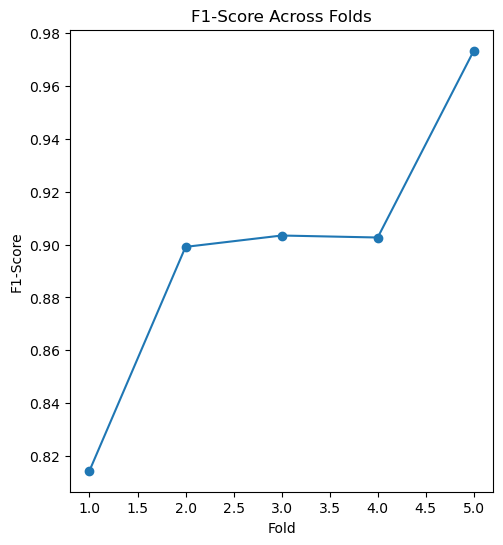

In [5]:
# Step 7: Plot Results
# Plot F1-scores and AUC for each fold
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), fold_f1_scores, label='F1-Score', marker='o')
plt.xlabel('Fold')
plt.ylabel('F1-Score')
plt.title('F1-Score Across Folds')

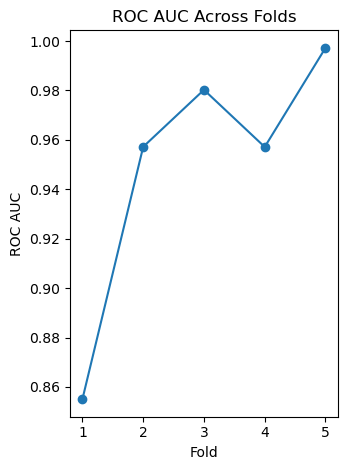

In [6]:
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), fold_roc_aucs, label='ROC AUC', marker='o')
plt.xlabel('Fold')
plt.ylabel('ROC AUC')
plt.title('ROC AUC Across Folds')

plt.tight_layout()
plt.show()